In [1]:
# pseduo code
import rasterio
import shap
from rasterio.mask import mask
from rasterio.windows import from_bounds
from rasterio.transform import from_bounds 
import numpy as np
import sys
import os
import subprocess
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.utils import register_keras_serializable
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Input, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

start_time = time.time()
print("modules established")

## establish file paths
years = list(range(2022, 2025))
Domain = "Rockies"
SHAP = "N"

# workspaces
WorkspaceBase = f"D:/ASOML/{Domain}/"
phv_features = WorkspaceBase + "features/scaled/"
tree_workspace = WorkspaceBase + "treeCover/"
land_workspace = WorkspaceBase + "landCover/"
modelOuptuts = WorkspaceBase + "modelOutputs/"
final_activation = 'relu'

## seting folder
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# create folder for model outputs
os.makedirs(modelOuptuts + f"{str(timestamp)}/", exist_ok=True)
inter_model_outWorkspace = modelOuptuts + f"{str(timestamp)}/"

f = open(inter_model_outWorkspace + f"code_output_{timestamp}.txt", "a")
sys.stdout = f
print("MODEL OUTPUTS TO BE PRINTED TO THIS DOC")

modules established


In [2]:
## function for min-max scaling
def min_max_scale(data, min_val=None, max_val=None, feature_range=(0, 1)):
    """Min-Max normalize a NumPy array to a target range."""
    data = data.astype(np.float32)
    mask = np.isnan(data)

    d_min = np.nanmin(data) if min_val is None else min_val
    d_max = np.nanmax(data) if max_val is None else max_val

    # if d_max == d_min:
    #     raise ValueError("Min and max are equal — can't scale.")
    if d_max == d_min:
        return np.full_like(data, feature_range[0], dtype=np.float32)

    a, b = feature_range
    scaled = (data - d_min) / (d_max - d_min)  # to [0, 1]
    scaled = scaled * (b - a) + a              # to [a, b]

    scaled[mask] = np.nan  # preserve NaNs
    return scaled

In [3]:
def model_predict(X):
    """
    Wrapper function to get predictions from the model.
    For CNNs with spatial outputs, you might want to either:
    1. Focus on one specific pixel location or
    2. Average across all spatial dimensions
    """
    preds = model.predict(X)
    # For a model with many output pixels (65536 in your case), you might want to:
    # - Either focus on specific pixels
    # - Or aggregate across all pixels (e.g., mean)
    return preds.reshape(X.shape[0], -1)  # Reshape to (batch_size, all_pixels)

In [4]:
def read_aligned_raster(src_path, extent, target_shape, nodata_val=-1):
    height, width = target_shape
    transform = from_bounds(*extent, width=width, height=height)

    with rasterio.open(src_path) as src:
        try:
            data = src.read(
                1,
                out_shape=target_shape,
                resampling=rasterio.enums.Resampling.nearest,
                window=src.window(*extent)
            )
        except Exception as e:
            print(f"Failed to read {src_path}: {e}")
            return np.full(target_shape, nodata_val, dtype=np.float32)

        # Handle nodata in source
        src_nodata = src.nodata
        if src_nodata is not None:
            data = np.where(data == src_nodata, np.nan, data)

        # Replace NaNs or invalid with -1
        data = np.where(np.isnan(data), nodata_val, data)

        return data

In [5]:
def save_array_as_raster(output_path, array, extent, crs, nodata_val=-1):
    height, width = array.shape
    transform = from_bounds(*extent, width=width, height=height)
    
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=array.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata_val
    ) as dst:
        dst.write(array, 1)

In [6]:
# split up the features and arrarys 
## create empty arrays
featureArray = []
targetArray = []

# loop through the years and feature data
for year in years:
    print(f"Processing year {year}")
    targetSplits = WorkspaceBase + f"{year}/SWE_processed_splits/"
    fSCAWorkspace = WorkspaceBase + f"{year}/fSCA/"
    for sample in os.listdir(targetSplits):
        featureTuple = ()
        featureName = []
        # loop through each sample and get the corresponding features
        if sample.endswith("nonull_fnl_2.tif"):
            # read in data
            with rasterio.open(targetSplits + sample) as samp_src:
                samp_data = samp_src.read(1)
                meta = samp_src.meta.copy()
                samp_extent = samp_src.bounds
                samp_transform = samp_src.transform
                samp_crs = samp_src.crs
    
                # apply a mask to all no data values. Reminder that nodata values is -9999
                mask = samp_data >= 0
                msked_target = np.where(mask, samp_data, -1)
                target_shape = msked_target.shape
    
                # flatted data
                samp_flat = msked_target.flatten()
                

            # try to get the fsca variables 
            sample_root = "_".join(sample.split("_")[:2])
            for fSCA in os.listdir(fSCAWorkspace):
                if fSCA.endswith(".tif") and fSCA.startswith(sample_root):
                    # featureName.append(f"fSCA")
                    featureName.append(f"fSCA")
                    fsca_norm = read_aligned_raster(src_path=fSCAWorkspace + fSCA, extent=samp_extent, target_shape=target_shape)
                    fsca_norm = min_max_scale(fsca_norm, min_val=0, max_val=100)
                    featureTuple += (fsca_norm,)
                    # print(fsca_norm.shape)
                    if fsca_norm.shape != (256, 256):
                        print(f"WRONG SHAPE FOR {sample}: FSCA")
                        output_debug_path = f"./debug_output/{sample_root}_BAD_FSCA.tif"
                        save_array_as_raster(
                            output_path=output_debug_path,
                            array=fsca_norm,
                            extent=samp_extent,
                            crs=samp_crs,
                            nodata_val=-1
                        )
    
            # get a DOY array into a feature 
            date_string = sample.split("_")[1]
            doy_str = date_string[-3:]
            doy = float(doy_str)
            DOY_array = np.full_like(msked_target, doy)
            doy_norm = min_max_scale(DOY_array,  min_val=0, max_val=366)
            featureTuple += (doy_norm,)
            featureName.append("DOY")
    
            # get the vegetation array
            for tree in os.listdir(tree_workspace):
                if tree.endswith(".tif"):
                    if tree.startswith(f"{year}"):
                        # featureName.append(f"{tree[:-4]}")
                        featureName.append(f"Tree Density")
                        tree_norm = read_aligned_raster(
                        src_path=tree_workspace + tree,
                        extent=samp_extent,
                        target_shape=target_shape
                        )
                        tree_norm = min_max_scale(tree_norm, min_val=0, max_val=100)
                        featureTuple += (tree_norm,)
                        if tree_norm.shape != (256, 256):
                            print(f"WRONG SHAPE FOR {sample}: TREE")
                            output_debug_path = f"./debug_output/{sample_root}_BAD_TREE.tif"
                            save_array_as_raster(
                                output_path=output_debug_path,
                                array=tree_norm,
                                extent=samp_extent,
                                crs=samp_crs,
                                nodata_val=-1
                            )
            # get the vegetation array
            for land in os.listdir(land_workspace):
                if land.endswith(".tif"):
                    if land.startswith(f"{year}"):
                        # featureName.append(f"{tree[:-4]}")
                        featureName.append(f"LandCover")
                        land_norm = read_aligned_raster(
                        src_path=land_workspace + land,
                        extent=samp_extent,
                        target_shape=target_shape
                        )
                        land_norm = min_max_scale(land_norm, min_val=11, max_val=95)
                        featureTuple += (land_norm,)
                        if land_norm.shape != (256, 256):
                            print(f"WRONG SHAPE FOR {sample}: Land")
                            # output_debug_path = f"./debug_output/{sample_root}_BAD_TREE.tif"
                            save_array_as_raster(
                                output_path=output_debug_path,
                                array=land_norm,
                                extent=samp_extent,
                                crs=samp_crs,
                                nodata_val=-1
                            )
            
            # # get all the features in the fodler 
            for phv in os.listdir(phv_features):
                if phv.endswith(".tif"):
                    featureName.append(f"{phv[:-4]}")
                    phv_data = read_aligned_raster(src_path=phv_features + phv, extent=samp_extent, target_shape=target_shape)
                    featureTuple += (phv_data,)
                    if phv_data.shape != (256, 256):
                         print(f"WRONG SHAPE FOR {sample}: {phv}")
                        
            feature_stack = np.dstack(featureTuple)
            if feature_stack.shape[2] != 19:
                print(f"{sample} has shape {feature_stack.shape} — missing or extra feature?")
                print(featureName)
                print(" ")
            else:
                featureArray.append(feature_stack)
                targetArray.append(samp_flat)
X = np.array(featureArray)
y = np.array(targetArray)

In [7]:
print("")
print("Shape of input data")
print(f"feature shape: {X.shape}")
print(f"target shape: {y.shape}")

In [8]:
# split between training and test data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True)
print("***")
print("________________________________ Training and Validation Data Shapes ________________________________")
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_valid.shape, y_valid.shape)
print("***")

In [9]:
# code model 
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 19), padding='valid'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2), padding='valid'))

# add stacked convolutions
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2), padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2), padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2), padding='valid'))

model.add(Flatten())
model.add(Dropout(0.1))

# dense layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# output layer
model.add(Dense(65536, activation=final_activation))

In [10]:
@register_keras_serializable()
def masked_loss_fn(y_true, y_pred, loss_fn, mask_value=-1):
    mask = tf.not_equal(y_true, mask_value)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return loss_fn(y_true_masked, y_pred_masked)

@register_keras_serializable(name="masked_mse")
def masked_mse(y_true, y_pred):
    return masked_loss_fn(y_true, y_pred, MeanSquaredError())

@register_keras_serializable(name="masked_mae")
def masked_mae(y_true, y_pred):
    return masked_loss_fn(y_true, y_pred, MeanAbsoluteError())

@register_keras_serializable(name="masked_rmse")
def masked_rmse(y_true, y_pred):
    mse = masked_loss_fn(y_true, y_pred, MeanSquaredError())
    return tf.sqrt(mse)

def constrained_mse(fsca_channel_index):
    def loss(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)

        # Reshape predictions back to (batch_size, 256, 256)
        y_pred_reshaped = tf.reshape(y_pred, (-1, 256, 256))

        # Grab fSCA input from the input tensor (assumes you feed it into model.fit)
        fsca_input = tf.keras.backend.placeholder(shape=(None, 256, 256, 19))  # you’ll override this in fit

        fsca = fsca_input[..., fsca_channel_index]

        # Create a mask for where fSCA > 0 but y_pred <= 0
        violation_mask = tf.logical_and(fsca > 0, y_pred_reshaped <= 0)
        violation_penalty = tf.cast(violation_mask, tf.float32) * 100.0  # 100 is an arbitrary penalty factor

        penalty = tf.reduce_mean(violation_penalty, axis=[1, 2])  # penalize across spatial dimensions
        return mse + penalty
    return loss


In [11]:
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Fetch batch data
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]

        # Optionally, do preprocessing or masking here
        # (e.g., ensure y_batch is ready for custom loss with -1 masking)
        y_batch[y_batch == -1] = 0

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [12]:
# uploading and saving model stats
checkpoint = ModelCheckpoint(
    f"{inter_model_outWorkspace}/best_model_{timestamp}.keras", monitor="val_masked_rmse",
    verbose=1, save_best_only=True, mode='min'
)
early_stopping = EarlyStopping(monitor="val_masked_rmse", mode='min', verbose=1, patience=10, restore_best_weights=True)

#compile
model.compile(
    optimizer='adam',
    loss=masked_mse,  # function version, already mask-aware
    metrics=[masked_rmse, masked_mae, masked_mse]
)

# get model summary
model.summary()

In [13]:
# establish the model
batch_size = 32
train_generator = DataGenerator(X_train, y_train, batch_size=batch_size)
valid_generator = DataGenerator(X_valid, y_valid, batch_size=batch_size)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    callbacks=[checkpoint, early_stopping]
)

In [14]:
if SHAP == "Y":
    try:
        print("SHAP: running SHAP")
        
        # Steps 1-4 as in the previous code
        background_data = X_train[:20]
        print("####background data established")
        explainer = shap.GradientExplainer(model, background_data)
        print("####explainer established")
        examples_to_explain = X_valid[:10]
        shap_values = explainer.shap_values(examples_to_explain)
        print("####shap values determined")
        
        # Calculate mean absolute SHAP value for each channel
        channel_importance = np.abs(shap_values[0]).mean(axis=(0, 1, 2))
        print("####calculating channel importances")
        
        # Create channel importance plot with feature names
        plt.figure(figsize=(14, 7))
        bars = plt.bar(range(18), channel_importance)
        plt.xlabel('Channels', fontsize=12)
        plt.ylabel('Mean |SHAP value|', fontsize=12)
        plt.title('Channel Importance by Feature', fontsize=14)
        print("####channel importance created")
        
        # Use the feature names as x-tick labels
        plt.xticks(range(18), featureName, rotation=45, ha='right', fontsize=10)
        
        # Add values on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                     f'{height:.4f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(inter_model_outWorkspace + 'channel_importance_with_features.png', dpi=300)
        plt.show()
        
        # You can also create a sorted version to see the most important features first
        sorted_idx = np.argsort(channel_importance)[::-1]  
        sorted_importance = channel_importance[sorted_idx]
        sorted_features = [featureName[i] for i in sorted_idx]
        
        plt.figure(figsize=(14, 7))
        bars = plt.bar(range(18), sorted_importance)
        plt.xlabel('Channels', fontsize=12)
        plt.ylabel('Mean |SHAP value|', fontsize=12)
        plt.title('Channel Importance by Feature (Sorted)', fontsize=14)
        plt.xticks(range(18), sorted_features, rotation=45, ha='right', fontsize=10)
        
        # Add values on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                     f'{height:.4f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(inter_model_outWorkspace + 'sorted_channel_importance.png', dpi=300)
        plt.show()
    except Exception as ex:
        print(ex)
else:
    print("SHAP was not run")

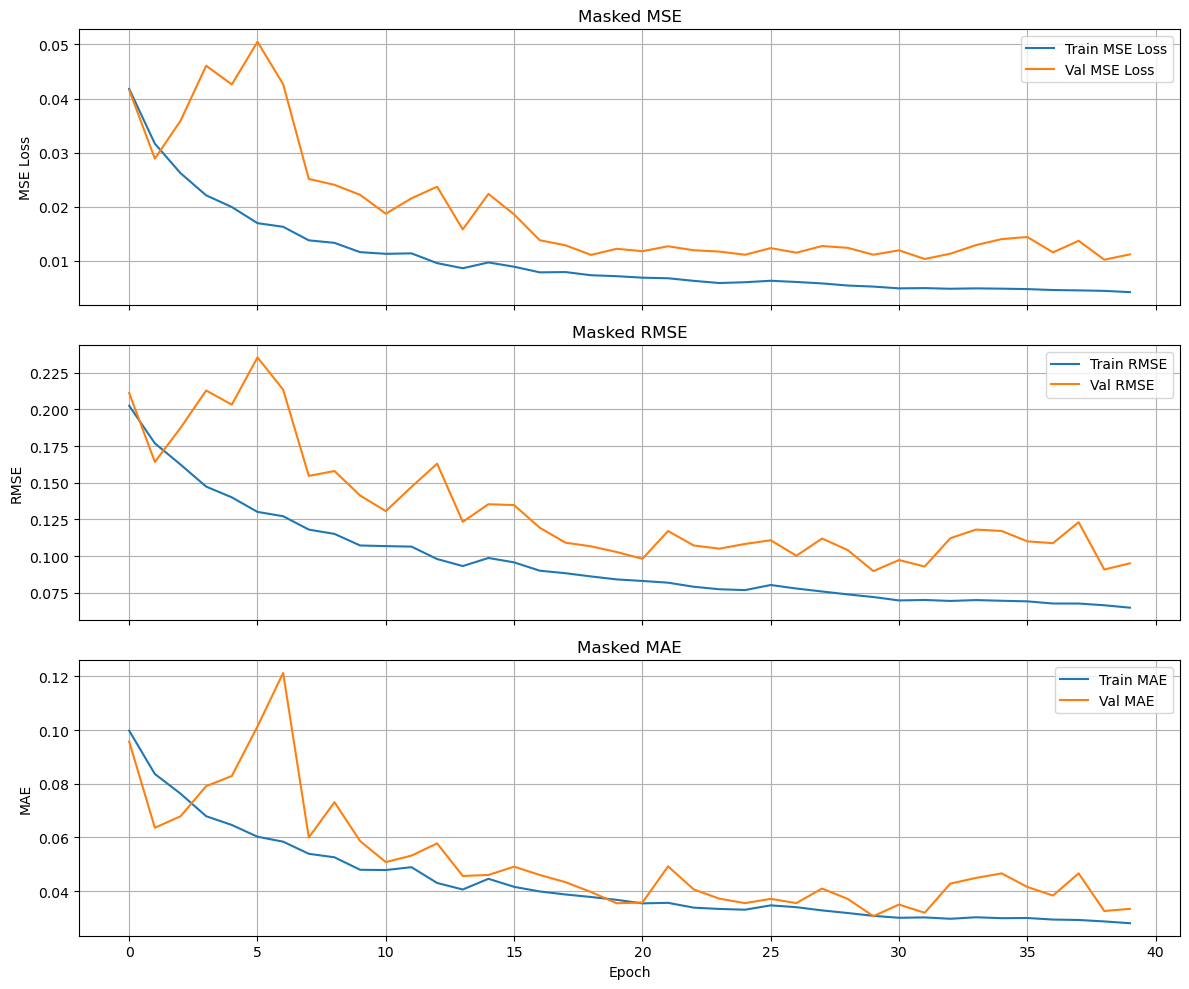

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Masked MSE (used as loss)
axs[0].plot(history.history['loss'], label='Train MSE Loss')
axs[0].plot(history.history['val_loss'], label='Val MSE Loss')
axs[0].set_ylabel('MSE Loss')
axs[0].set_title('Masked MSE')
axs[0].legend()
axs[0].grid(True)

# 2. Masked RMSE
axs[1].plot(history.history['masked_rmse'], label='Train RMSE')
axs[1].plot(history.history['val_masked_rmse'], label='Val RMSE')
axs[1].set_ylabel('RMSE')
axs[1].set_title('Masked RMSE')
axs[1].legend()
axs[1].grid(True)

# 3. Masked MAE
axs[2].plot(history.history['masked_mae'], label='Train MAE')
axs[2].plot(history.history['val_masked_mae'], label='Val MAE')
axs[2].set_ylabel('MAE')
axs[2].set_title('Masked MAE')
axs[2].set_xlabel('Epoch')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.savefig(inter_model_outWorkspace + "Model_error_epochs.png")
plt.show()


In [16]:
metrics_to_track = ['val_masked_rmse', 'val_masked_mse', 'val_masked_mae']

print("\nValidation Metric Progression:")
for metric in metrics_to_track:
    values = history.history.get(metric, [])
    if values:
        print(f"{metric}: Start = {values[0]:.4f}, End = {values[-1]:.4f}")
        print(f"{metric}: Best = {min(values):.4f}")
    else:
        print(f"{metric}: Not found in history.")

print(f"Final activation function: {final_activation}")

In [17]:
# testing out this function with test date
# split up the features and arrarys 
def target_feature_stacks(start_year, end_year, target_splits_path, fSCA_path, vegetation_path, landCover_path, phv_path, extension_filter, desired_shape, debug_output_folder, num_of_channels):
        ## create empty arrays
        years = list(range(start_year, (int(end_year) + 1)))
        featureArray = []
        targetArray = []
        extent_list = []
        crs_list = []
        
        # loop through the years and feature data
        for year in years:
            print(f"Processing {year}")
            targetSplits = target_splits_path
            fSCAWorkspace = fSCA_path
            for sample in os.listdir(targetSplits):
                featureTuple = ()
                featureName = []
                # loop through each sample and get the corresponding features
                if sample.endswith(extension_filter):
                    # read in data
                    with rasterio.open(targetSplits + sample) as samp_src:
                        samp_data = samp_src.read(1)
                        meta = samp_src.meta.copy()
                        samp_extent = samp_src.bounds
                        samp_transform = samp_src.transform
                        samp_crs = samp_src.crs
                        # apply a no-data mask
                        mask = samp_data >= 0
                        msked_target = np.where(mask, samp_data, -1)
                        target_shape = msked_target.shape
            
                        # flatted data
                        samp_flat = msked_target.flatten()
                        
        
                    # try to get the fsca variables 
                    sample_root = "_".join(sample.split("_")[:2])
                    for fSCA in os.listdir(fSCAWorkspace):
                        if fSCA.endswith(extension_filter) and fSCA.startswith(sample_root):
                            featureName.append(f"{fSCA[:-4]}")
                            fsca_norm = read_aligned_raster(src_path=fSCAWorkspace + fSCA, extent=samp_extent, target_shape=target_shape)
                            fsca_norm = min_max_scale(fsca_norm, min_val=0, max_val=100)
                            featureTuple += (fsca_norm,)
                            # print(fsca_norm.shape)
                            if fsca_norm.shape != desired_shape:
                                print(f"WRONG SHAPE FOR {sample}: FSCA")
                                output_debug_path = debug_output_folder + f"/{sample_root}_BAD_FSCA.tif"
                                save_array_as_raster(
                                    output_path=output_debug_path,
                                    array=fsca_norm,
                                    extent=samp_extent,
                                    crs=samp_crs,
                                    nodata_val=-1
                                )
            
                    # get a DOY array into a feature 
                    date_string = sample.split("_")[1]
                    doy_str = date_string[-3:]
                    doy = float(doy_str)
                    DOY_array = np.full_like(msked_target, doy)
                    doy_norm = min_max_scale(DOY_array,  min_val=0, max_val=366)
                    featureTuple += (doy_norm,)
                    featureName.append(doy)
            
                    # get the vegetation array
                    for tree in os.listdir(vegetation_path):
                        if tree.endswith(extension_filter):
                            if tree.startswith(f"{year}"):
                                featureName.append(f"{tree[:-4]}")
                                tree_norm = read_aligned_raster(
                                src_path=tree_workspace + tree,
                                extent=samp_extent,
                                target_shape=target_shape
                                )
                                tree_norm = min_max_scale(tree_norm, min_val=0, max_val=100)
                                featureTuple += (tree_norm,)
                                if tree_norm.shape != desired_shape:
                                    print(f"WRONG SHAPE FOR {sample}: TREE")
                                    output_debug_path = debug_output_folder + f"/{sample_root}_BAD_TREE.tif"
                                    save_array_as_raster(
                                        output_path=output_debug_path,
                                        array=fsca_norm,
                                        extent=samp_extent,
                                        crs=samp_crs,
                                        nodata_val=-1
                                    )
                    
                    # get the vegetation array
                    for land in os.listdir(land_workspace):
                        if land.endswith(".tif"):
                            if land.startswith(f"{year}"):
                                # featureName.append(f"{tree[:-4]}")
                                featureName.append(f"LandCover")
                                land_norm = read_aligned_raster(
                                src_path=tree_workspace + land,
                                extent=samp_extent,
                                target_shape=target_shape
                                )
                                land_norm = min_max_scale(land_norm, min_val=11, max_val=95)
                                featureTuple += (land_norm,)
                                if land_norm.shape != (256, 256):
                                    print(f"WRONG SHAPE FOR {sample}: Land")
                                    # output_debug_path = f"./debug_output/{sample_root}_BAD_TREE.tif"
                                    save_array_as_raster(
                                        output_path=output_debug_path,
                                        array=fsca_norm,
                                        extent=samp_extent,
                                        crs=samp_crs,
                                        nodata_val=-1
                                    )
                    
            
                    # # get all the features in the fodler 
                    for phv in os.listdir(phv_path):
                        if phv.endswith(extension_filter):
                            featureName.append(f"{phv[:-4]}")
                            phv_data = read_aligned_raster(src_path=phv_features + phv, extent=samp_extent, target_shape=target_shape)
                            featureTuple += (phv_data,)
                            if phv_data.shape != desired_shape:
                                print(f"WRONG SHAPE FOR {sample}: {phv}")
                                output_debug_path = debug_output_folder + f"/{sample_root}_BAD_{phv[:-4]}.tif"
                                save_array_as_raster(
                                    output_path=output_debug_path,
                                    array=fsca_norm,
                                    extent=samp_extent,
                                    crs=samp_crs,
                                    nodata_val=-1
                                )
                    feature_stack = np.dstack(featureTuple)
                    if feature_stack.shape[2] != num_of_channels:
                        print(f"{sample} has shape {feature_stack.shape} — missing or extra feature?")
                        print(featureName)
                        print(" ")
                    else:
                        featureArray.append(feature_stack)
                        targetArray.append(samp_flat)
                        extent_list.append(samp_extent)
                        crs_list.append(samp_crs)
        return  np.array(featureArray), np.array(targetArray), extent_list, crs_list

In [18]:
# testing out this function with test date
# split up the features and arrarys 
def target_feature_stacks_testGroups(year, target_splits_path, fSCA_path, vegetation_path, landCover_path, phv_path, extension_filter, desired_shape, debug_output_folder, num_of_channels):
        ## create empty arrays
        featureArray = []
        targetArray = []
        extent_list = []
        crs_list = []
        
        # loop through the years and feature data
        # print(f"Processing {group}")
        targetSplits = target_splits_path
        fSCAWorkspace = fSCA_path
        for sample in os.listdir(targetSplits):
            featureTuple = ()
            featureName = []
            # loop through each sample and get the corresponding features
            if sample.endswith(extension_filter):
                # read in data
                with rasterio.open(targetSplits + sample) as samp_src:
                    samp_data = samp_src.read(1)
                    meta = samp_src.meta.copy()
                    samp_extent = samp_src.bounds
                    samp_transform = samp_src.transform
                    samp_crs = samp_src.crs
                    # apply a no-data mask
                    mask = samp_data >= 0
                    msked_target = np.where(mask, samp_data, -1)
                    target_shape = msked_target.shape
        
                    # flatted data
                    samp_flat = msked_target.flatten()
                    
    
                # try to get the fsca variables 
                sample_root = "_".join(sample.split("_")[:2])
                for fSCA in os.listdir(fSCAWorkspace):
                    if fSCA.endswith(extension_filter) and fSCA.startswith(sample_root):
                        featureName.append(f"{fSCA[:-4]}")
                        fsca_norm = read_aligned_raster(src_path=fSCAWorkspace + fSCA, extent=samp_extent, target_shape=target_shape)
                        fsca_norm = min_max_scale(fsca_norm, min_val=0, max_val=100)
                        featureTuple += (fsca_norm,)
                        # print(fsca_norm.shape)
                        if fsca_norm.shape != desired_shape:
                            print(f"WRONG SHAPE FOR {sample}: FSCA")
                            output_debug_path = debug_output_folder + f"/{sample_root}_BAD_FSCA.tif"
                            save_array_as_raster(
                                output_path=output_debug_path,
                                array=fsca_norm,
                                extent=samp_extent,
                                crs=samp_crs,
                                nodata_val=-1
                            )
        
                # get a DOY array into a feature 
                date_string = sample.split("_")[1]
                doy_str = date_string[-3:]
                doy = float(doy_str)
                DOY_array = np.full_like(msked_target, doy)
                doy_norm = min_max_scale(DOY_array,  min_val=0, max_val=366)
                featureTuple += (doy_norm,)
                featureName.append(doy)
        
                # get the vegetation array
                for tree in os.listdir(vegetation_path):
                    if tree.endswith(extension_filter):
                        if tree.startswith(f"{year}"):
                            featureName.append(f"{tree[:-4]}")
                            tree_norm = read_aligned_raster(
                            src_path=tree_workspace + tree,
                            extent=samp_extent,
                            target_shape=target_shape
                            )
                            tree_norm = min_max_scale(tree_norm, min_val=0, max_val=100)
                            featureTuple += (tree_norm,)
                            if tree_norm.shape != desired_shape:
                                print(f"WRONG SHAPE FOR {sample}: TREE")
                                output_debug_path = debug_output_folder + f"/{sample_root}_BAD_TREE.tif"
                                save_array_as_raster(
                                    output_path=output_debug_path,
                                    array=fsca_norm,
                                    extent=samp_extent,
                                    crs=samp_crs,
                                    nodata_val=-1
                                )
                # get the vegetation array
                for land in os.listdir(land_workspace):
                    if land.endswith(".tif"):
                        if land.startswith(f"{year}"):
                            # featureName.append(f"{tree[:-4]}")
                            featureName.append(f"LandCover")
                            land_norm = read_aligned_raster(
                            src_path=land_workspace + land,
                            extent=samp_extent,
                            target_shape=target_shape
                            )
                            land_norm = min_max_scale(land_norm, min_val=11, max_val=95)
                            featureTuple += (land_norm,)
                            if land_norm.shape != (256, 256):
                                print(f"WRONG SHAPE FOR {sample}: Land")
                                # output_debug_path = f"./debug_output/{sample_root}_BAD_TREE.tif"
                                save_array_as_raster(
                                    output_path=output_debug_path,
                                    array=fsca_norm,
                                    extent=samp_extent,
                                    crs=samp_crs,
                                    nodata_val=-1
                                )
                
                # # get all the features in the fodler 
                for phv in os.listdir(phv_path):
                    if phv.endswith(extension_filter):
                        featureName.append(f"{phv[:-4]}")
                        phv_data = read_aligned_raster(src_path=phv_features + phv, extent=samp_extent, target_shape=target_shape)
                        featureTuple += (phv_data,)
                        if phv_data.shape != desired_shape:
                            print(f"WRONG SHAPE FOR {sample}: {phv}")
                            output_debug_path = debug_output_folder + f"/{sample_root}_BAD_{phv[:-4]}.tif"
                            save_array_as_raster(
                                output_path=output_debug_path,
                                array=fsca_norm,
                                extent=samp_extent,
                                crs=samp_crs,
                                nodata_val=-1
                            )
                feature_stack = np.dstack(featureTuple)
                if feature_stack.shape[2] != num_of_channels:
                    print(f"{sample} has shape {feature_stack.shape} — missing or extra feature?")
                    print(featureName)
                    print(" ")
                else:
                    featureArray.append(feature_stack)
                    targetArray.append(samp_flat)
                    extent_list.append(samp_extent)
                    crs_list.append(samp_crs)
        # print("You go girl!")
        # print("all data split into target and feature array")
        return  np.array(featureArray), np.array(targetArray), extent_list, crs_list

In [19]:
# create folder
print("############### MOVING TO TEST GROUPS OF DATA. FINGERS CROSSED! ###############")
print("Testing Group 1")
os.makedirs(inter_model_outWorkspace + f"outTifs_G1_yPreds_tifs/", exist_ok=True)
outGroup1 = inter_model_outWorkspace + f"outTifs_G1_yPreds_tifs/"
X_train_g1, y_train_g1, g1_train_extents, g1_train_crs = target_feature_stacks_testGroups(year=2022, 
                                                   target_splits_path = WorkspaceBase + f"test_groups/Group1/train/", 
                                                   fSCA_path = WorkspaceBase + f"2024/fSCA/", 
                                                   vegetation_path = WorkspaceBase + "treeCover/", 
                                                   landCover_path = land_workspace,
                                                   phv_path = WorkspaceBase + "features/scaled/", 
                                                   extension_filter = ".tif", 
                                                   desired_shape = (256, 256), 
                                                   debug_output_folder = "./debug_outputs/", 
                                                   num_of_channels = 19)
X_test_g1, y_test_g1, g1_test_extents, g1_test_crs = target_feature_stacks_testGroups(year = 2022,
                                               target_splits_path = WorkspaceBase + f"test_groups/Group1/test/", 
                                               fSCA_path = WorkspaceBase + f"2024/fSCA/", 
                                               vegetation_path = WorkspaceBase + "treeCover/",
                                               landCover_path = land_workspace,                                       
                                               phv_path = WorkspaceBase + "features/scaled/", 
                                               extension_filter = ".tif", 
                                               desired_shape = (256, 256), 
                                               debug_output_folder = "./debug_outputs/", 
                                               num_of_channels = 19)

from tensorflow.keras.models import load_model

# Custom loss function must be re-declared if you used one
model = load_model(f"{inter_model_outWorkspace}/best_model_{timestamp}.keras", custom_objects={
    'loss': masked_rmse
})

# Convert lists to NumPy arrays if they aren't already
X_test_array_g1 = np.array(X_test_g1)
y_test_array_g1 = np.array(y_test_g1)

# Make sure shapes are correct for model input
print(f"X_test shape: {X_test_array_g1.shape}")  # should be (num_samples, 256, 256, num_channels)
print(f"y_test shape: {y_test_array_g1.shape}")  # should be (num_samples, 256, 256, 1) or (num_samples, 256, 256)

# model predictions
y_pred_g1 = model.predict(X_test_array_g1, batch_size=5)

# test loss
loss = model.evaluate(X_test_array_g1, y_test_array_g1, batch_size=32)

for i, pred in enumerate(y_pred_g1):
    array = pred.reshape((256, 256))
    mask = y_test_g1[i].reshape((256, 256)) != -1  # True where data is valid
    
    # Apply mask: set prediction to -1 where original target had no data
    array_masked = np.where(mask, array, -1)
    save_array_as_raster(
        output_path=f"{outGroup1}/prediction_{i}.tif",
        array=array_masked.astype(np.float32),
        extent=g1_test_extents[i],
        crs=g1_test_crs[i],
        nodata_val=-1
    )

# Print test loss and metrics
metrics = model.evaluate(X_test_array_g1, y_test_array_g1, batch_size=32, return_dict=True)
print("\n Test Group 1 Metrics:")
print(f"Masked MSE (Loss): {metrics['loss']:.4f}")
print(f"Masked RMSE:       {metrics['masked_rmse']:.4f}")
print(f"Masked MAE:        {metrics['masked_mae']:.4f}")
print(f"Masked MSE Metric: {metrics['masked_mse']:.4f}")

In [20]:
# create folder
print("\n Testing Group 2")
os.makedirs(inter_model_outWorkspace + f"outTifs_G2_yPreds_tifs/", exist_ok=True)
outGroup2 = inter_model_outWorkspace + f"outTifs_G2_yPreds_tifs/"

X_train_g2, y_train_g2, g2_train_extents, g2_train_crs = target_feature_stacks_testGroups(year=2025, 
                                                   target_splits_path = WorkspaceBase + f"test_groups/Group2/train/", 
                                                   fSCA_path = WorkspaceBase + f"2025/fSCA/", 
                                                   vegetation_path = WorkspaceBase + "treeCover/",
                                                   landCover_path = land_workspace,
                                                   phv_path = WorkspaceBase + "features/scaled/", 
                                                   extension_filter = ".tif", 
                                                   desired_shape = (256, 256), 
                                                   debug_output_folder = "./debug_outputs/", 
                                                   num_of_channels = 19)
X_test_g2, y_test_g2, g2_test_extents, g2_test_crs = target_feature_stacks_testGroups(year = 2025,
                                               target_splits_path = WorkspaceBase + f"test_groups/Group2/test/", 
                                               fSCA_path = WorkspaceBase + f"2025/fSCA/", 
                                               vegetation_path = WorkspaceBase + "treeCover/", 
                                               landCover_path = land_workspace,
                                               phv_path = WorkspaceBase + "features/scaled/", 
                                               extension_filter = ".tif", 
                                               desired_shape = (256, 256), 
                                               debug_output_folder = "./debug_outputs/", 
                                               num_of_channels = 19)

from tensorflow.keras.models import load_model

# Custom loss function must be re-declared if you used one
model = load_model(f"{inter_model_outWorkspace}/best_model_{timestamp}.keras", custom_objects={
    'loss': masked_rmse
})


# Convert lists to NumPy arrays if they aren't already
X_test_array_g2 = np.array(X_test_g2)
y_test_array_g2 = np.array(y_test_g2)

# Make sure shapes are correct for model input
print(f"X_test shape: {X_test_array_g2.shape}")  # should be (num_samples, 256, 256, num_channels)
print(f"y_test shape: {y_test_array_g2.shape}")  # should be (num_samples, 256, 256, 1) or (num_samples, 256, 256)

# model predictions
y_pred_g2 = model.predict(X_test_array_g2, batch_size=5)

# test loss
loss = model.evaluate(X_test_array_g2, y_test_array_g2, batch_size=32)

for i, pred in enumerate(y_pred_g2):
    array = pred.reshape((256, 256))
    mask = y_test_g2[i].reshape((256, 256)) != -1  # True where data is valid
    
    # Apply mask: set prediction to -1 where original target had no data
    array_masked = np.where(mask, array, -1)
    save_array_as_raster(
        output_path=f"{outGroup2}/prediction_{i}.tif",
        array=array_masked.astype(np.float32),
        extent=g2_test_extents[i],
        crs=g2_test_crs[i],
        nodata_val=-1
    )
# Print test loss and metrics
metrics = model.evaluate(X_test_array_g2, y_test_array_g2, batch_size=32, return_dict=True)
print("\n Test Group 2 Metrics:")
print(f"Masked MSE (Loss): {metrics['loss']:.4f}")
print(f"Masked RMSE:       {metrics['masked_rmse']:.4f}")
print(f"Masked MAE:        {metrics['masked_mae']:.4f}")
print(f"Masked MSE Metric: {metrics['masked_mse']:.4f}")

In [21]:
# # create folder
# print("\n Testing Group 3")
# os.makedirs(inter_model_outWorkspace + f"outTifs_G3_yPreds_tifs/", exist_ok=True)
# outGroup3 = inter_model_outWorkspace + f"outTifs_G3_yPreds_tifs/"

# X_train_g3, y_train_g3, g3_train_extents, g3_train_crs = target_feature_stacks_testGroups(year=2024, 
#                                                    target_splits_path = WorkspaceBase + f"test_groups/Group3/train/", 
#                                                    fSCA_path = WorkspaceBase + f"2024/fSCA/", 
#                                                    vegetation_path = WorkspaceBase + "treeCover/",  
#                                                    landCover_path = land_workspace,
#                                                    phv_path = WorkspaceBase + "features/scaled/", 
#                                                    extension_filter = ".tif", 
#                                                    desired_shape = (256, 256), 
#                                                    debug_output_folder = "./debug_outputs/", 
#                                                    num_of_channels = 18)
# X_test_g3, y_test_g3, g3_test_extents, g3_test_crs = target_feature_stacks_testGroups(year = 2024,
#                                                target_splits_path = WorkspaceBase + f"test_groups/Group3/test/", 
#                                                fSCA_path = WorkspaceBase + f"2024/fSCA/", 
#                                                vegetation_path = WorkspaceBase + "treeCover/", 
#                                                landCover_path = land_workspace,
#                                                phv_path = WorkspaceBase + "features/scaled/", 
#                                                extension_filter = ".tif", 
#                                                desired_shape = (256, 256), 
#                                                debug_output_folder = "./debug_outputs/", 
#                                                num_of_channels = 18)

# from tensorflow.keras.models import load_model

# # Custom loss function must be re-declared if you used one
# model = load_model(f"{inter_model_outWorkspace}/best_model_{timestamp}.keras", custom_objects={
#     'loss': masked_rmse
# })


# # Convert lists to NumPy arrays if they aren't already
# X_test_array_g3 = np.array(X_test_g3)
# y_test_array_g3 = np.array(y_test_g3)

# # Make sure shapes are correct for model input
# print(f"X_test shape: {X_test_array_g3.shape}")  # should be (num_samples, 256, 256, num_channels)
# print(f"y_test shape: {y_test_array_g3.shape}")  # should be (num_samples, 256, 256, 1) or (num_samples, 256, 256)

# # model predictions
# y_pred_g3 = model.predict(X_test_array_g3, batch_size=32)

# # test loss
# loss = model.evaluate(X_test_array_g3, y_test_array_g3, batch_size=32)

# for i, pred in enumerate(y_pred_g3):
#     array = pred.reshape((256, 256))
#     mask = y_test_g3[i].reshape((256, 256)) != -1  # True where data is valid
    
#     # Apply mask: set prediction to -1 where original target had no data
#     array_masked = np.where(mask, array, -1)
#     save_array_as_raster(
#         output_path=f"{outGroup3}/prediction_{i}.tif",
#         array=array_masked.astype(np.float32),
#         extent=g3_test_extents[i],
#         crs=g3_test_crs[i],
#         nodata_val=-1
#     )

# # Print test loss and metrics
# metrics = model.evaluate(X_test_array_g3, y_test_array_g3, batch_size=32, return_dict=True)

# print("\n Test Group 3 Metrics:")
# print(f"Masked MSE (Loss): {metrics['loss']:.4f}")
# print(f"Masked RMSE:       {metrics['masked_rmse']:.4f}")
# print(f"Masked MAE:        {metrics['masked_mae']:.4f}")
# print(f"Masked MSE Metric: {metrics['masked_mse']:.4f}")

In [22]:
end_time = time.time()
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
print("\n Model Completed")
print(f"Training time: {total_minutes:.2f} minutes")